# Visualize Germany's Population using lonboard
In this notebook we’ll use the [`lonboard`](https://developmentseed.org/lonboard/) library to visualize Germany’s population data, which consists of approximately 3 million polygons. By the end, you'll know how to create interactive maps of large spatial datasets directly in Jupyter notebooks.

## Imports
`lonboard` is designed to work within Jupyter Notebooks. Please make sure you're working in a Jupyter environment to follow along.

Before starting, make sure you have the following packages installed:
- `lonboard` and its dependencies: `anywidget`, `geopandas`, `matplotlib`, `palettable`, `pandas` (which requires `numpy`), `pyarrow` and `shapely`.
- `requests`: For fetching data.
- `seaborn`: For statistical data visualization.

The following modules come standard with Python, so no need for separate installation:
- `zipfile`
- `io`

In [1]:
import requests
import zipfile
import io

from lonboard import Map, SolidPolygonLayer
from lonboard.layer_extension import DataFilterExtension
import ipywidgets as widgets

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker

from shapely.geometry import Polygon

import seaborn as sns

## Fetch Population Data
The population data we’ll be using is stored in a `.csv` file inside a ZIP folder. It consists of 100m x 100m grid cells covering the area of Germany, with population counts for each cell. We'll download this file, extract the data, and load it into a `pandas` DataFrame.

In [2]:
url = "https://www.zensus2022.de/static/Zensus_Veroeffentlichung/Zensus2022_Bevoelkerungszahl.zip"
target_file = "Zensus2022_Bevoelkerungszahl_100m-Gitter.csv"

response = requests.get(url)

if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref: # Open the ZIP file in memory
        if target_file in zip_ref.namelist():
            with zip_ref.open(target_file) as csv_file:
                df_pop = pd.read_csv(csv_file, delimiter=';') 
        else:
            print(f"{target_file} not found in the ZIP archive.")
else:
    print(f"Failed to download file: {response.status_code}")

Let’s take a quick look at the first few rows of the data to understand its structure:

In [3]:
df_pop.head()

,GITTER_ID_100m,x_mp_100m,y_mp_100m,Einwohner
0,CRS3035RES100mN2689100E4337000,4337050,2689150,4
1,CRS3035RES100mN2689100E4341100,4341150,2689150,11
2,CRS3035RES100mN2690800E4341200,4341250,2690850,4
3,CRS3035RES100mN2691200E4341200,4341250,2691250,12
4,CRS3035RES100mN2691300E4341200,4341250,2691350,3


While we can't immediately tell the meaning of each column just from looking at the data, the [data description](https://www.zensus2022.de/static/Zensus_Veroeffentlichung/Datensatzbeschreibung_Bevoelkerungszahl_Gitterzellen.xlsx) clarifies the following:
- `GITTER_ID_100m`: The unique identifier for each 100m x 100m grid cell.
- `x_mp_100m`: The longitude of the cell's center using the [ETRS89-LAEA Europe (EPSG: 3035)](https://epsg.io/3035) coordinate reference system.
- `y_mp_100m`: The latitude of the cell's center using the [ETRS89-LAEA Europe (EPSG: 3035)](https://epsg.io/3035) coordinate reference system.
- `Einwohner`: The population count within each cell.

## Prepare Data

In [4]:
df_pop.rename(columns={'Einwohner': 'Population'}, inplace=True)
df_pop['Population'] = pd.to_numeric(df_pop['Population'], errors='coerce') # coerce: any value that cannot be converted to a numeric type will be replaced with NaN

To visualize the data on a map, we need to transform the coordinates into polygons representing each grid cell. The dataset uses the ETRS89-LAEA Europe coordinate reference system, which measures distances in meters and is well-suited for European datasets.

Since each grid cell is 100m x 100m, and the coordinates provided represent the center of each cell, we can use this information—combined with the fact that the CRS measures in meters—to create accurate polygons. When creating the `geopandas` GeoDataFrame, we’ll ensure that the correct CRS (ETRS89-LAEA) is set. However, for visualization in `lonboard`, we need to convert the coordinates to the more commonly used [WGS84 (EPSG:4326)](https://epsg.io/4326) CRS, which is based on latitude and longitude.

The following code will generate `geopandas Polygons` for each cell and convert the CRS for visualization:

In [5]:
def create_polygon(x, y, half_length=50):
    return Polygon([
        (x - half_length, y - half_length),
        (x + half_length, y - half_length),
        (x + half_length, y + half_length),
        (x - half_length, y + half_length)
    ])
    
gdf_population = gpd.GeoDataFrame(df_pop['Population'], geometry=df_pop.apply(lambda row: create_polygon(row['x_mp_100m'], row['y_mp_100m']), axis=1), crs = 'EPSG:3035')

# Convert the coordinate system to WGS84 (EPSG:4326)
gdf_population = gdf_population.to_crs(epsg=4326)

In [6]:
gdf_population.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3088037 entries, 0 to 3088036
Data columns (total 2 columns):
 #   Column      Dtype   
---  ------      -----   
 0   Population  int64   
 1   geometry    geometry
dtypes: geometry(1), int64(1)
memory usage: 47.1 MB


In [7]:
gdf_population

,Population,geometry
0,4,"POLYGON ((10.21146 47.31529, 10.21278 47.31529..."
1,11,"POLYGON ((10.26565 47.31517, 10.26697 47.31517..."
2,4,"POLYGON ((10.26705 47.33047, 10.26837 47.33046..."
3,12,"POLYGON ((10.26707 47.33407, 10.26839 47.33407..."
4,3,"POLYGON ((10.26707 47.33497, 10.26839 47.33497..."
...,...,...
3088032,14,"POLYGON ((8.42288 55.02299, 8.42445 55.02301, ..."
3088033,4,"POLYGON ((8.41816 55.02383, 8.41972 55.02385, ..."
3088034,10,"POLYGON ((8.41972 55.02385, 8.42129 55.02387, ..."
3088035,3,"POLYGON ((8.42129 55.02387, 8.42285 55.02389, ..."


## Visualize Data Using `lonboard`

To visualize the population data, we use the [`SolidPolygonLayer`](https://developmentseed.org/lonboard/latest/api/layers/solid-polygon-layer/). This layer is preferred over [`PolygonLayer`](https://developmentseed.org/lonboard/latest/api/layers/polygon-layer/) because it does not render polygon outlines, making it more performant for large datasets.

We’ll create the `SolidPolygonLayer` from the `GeoDataFrame` we generated earlier and then add it to a `Map` for visualization:

In [8]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf_population,
)

m = Map(polygon_layer) 

In [9]:
m

Map(layers=[SolidPolygonLayer(table=pyarrow.Table
Population: uint16
geometry: list<item: list<item: fixed_siz…

### Set a Colormap
We can explore the documentation for [`SolidPolygonLayer`](https://developmentseed.org/lonboard/latest/api/layers/solid-polygon-layer/) to learn about the various rendering options it offers. Instead of using the default black fill color, let’s customize the appearance by setting a new one. Since `get_fill_color` is a mutable property, we can easily update the color dynamically after creating the layer, without needing to recreate it.

In [10]:
polygon_layer.get_fill_color = [11, 127, 171]

Blue is pretty, but let’s make our map more insightful by coloring each area based on its population. Using a [colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html) from `matplotlib`, we’ll scale the population values between 0 and 1. This will allow us to easily compare different population densities at a glance.

In [11]:
colormap = mpl.colormaps["YlOrRd"]
normalizer = mpl.colors.Normalize(0, vmax=gdf_population['Population'].max()) #Normalize population to the 0-1 range
colors = colormap(normalizer(gdf_population['Population']), bytes=True)

In [12]:
polygon_layer.get_fill_color = colors

The new colorscheme already makes the map more insightful. However, it looks like the red colors aren’t showing up much, which might suggest that our data is skewed. Let’s check

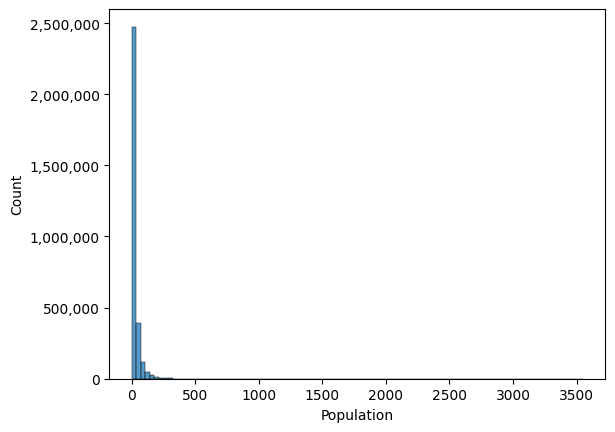

Skewness value: 4.7072006305650085


In [13]:
def thousands_formatter(x, pos):
    return f'{int(x):,}'
    
sns.histplot(gdf_population['Population'], bins=100)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

print("Skewness value:",gdf_population['Population'].skew())

The histogram and skewness reveal a strong positive skew — most cells have low populations, while only a few cells have very high numbers. This is why our linear colormap isn’t showing much color variation. To make these differences stand out, let’s switch to a logarithmic colormap, which will better highlight the variations in population density.

In [14]:
normalizer = mpl.colors.LogNorm(vmin=gdf_population['Population'].min(), vmax=gdf_population['Population'].max()) # Normalize population to the 0-1 range on a log scale.
colors = colormap(normalizer(gdf_population['Population']), bytes=True)

In [15]:
polygon_layer.get_fill_color = colors

### Add a Legend
To make our map even clearer, let’s add a colorbar that shows how population densities correspond to colors. This will help users easily interpret the map. 
Here’s how we can set it up:

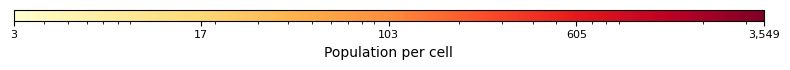

In [16]:
def create_colorbar():
    fig, ax = plt.subplots(figsize=(8, 0.8))
    
    # Define the colorbar with LogNorm and the specified colormap
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=LogNorm(vmin=gdf_population['Population'].min(), vmax=gdf_population['Population'].max()), cmap=colormap),
        cax=ax,
        orientation='horizontal'
    )
    
    tick_values = np.logspace(np.log10(gdf_population['Population'].min()), np.log10(gdf_population['Population'].max()), num=5)
    cbar.set_ticks(tick_values)
    cbar.ax.xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
    cbar.ax.tick_params(labelsize=8)

    cbar.set_label('Population per cell', fontsize=10)
    
    plt.tight_layout()
    plt.show()

create_colorbar()

By using Jupyter widgets, we can capture the colorbar and then combine it with the map for a more comprehensive view.

In [18]:
# Display the map and the colorbar together

# Create output widget for the colorbar
colorbar_output = widgets.Output()

with colorbar_output:
    create_colorbar()
    
widgets.VBox([m, colorbar_output])

### Share a Map
To share your interactive map, you can save it as an HTML file. This allows others to view and interact with the map in a web browser without needing any specialized software. 
Here’s a simple way to save your map as an HTML file:

In [19]:
m.to_html("visualization_population.html")

In [20]:
!open visualization_population.html

Be aware that saving to HTML embeds the entire dataset into the file, which can result in a large file size. This might not be the most efficient way to share large datasets.

An alternative solution is to use [`Shiny`](https://developmentseed.org/lonboard/latest/ecosystem/shiny/), which integrates with Jupyter Widgets and supports `lonboard`. Shiny allows you to host the map and data separately, providing a more efficient way to share interactive maps for larger datasets.

## Additional Customization
### Interactive Filtering
To make our map even more interactive, we can add filters that allow us to explore the data based on specific criteria. By incorporating widgets like sliders, we can dynamically adjust which data is displayed. For example, we can use a slider to filter and display only areas with populations within a certain range, offering a more focused view of the data.

Unlike the fill color, which is a mutable property that can be changed dynamically, applying filters requires the [`DataFilterExtension`](https://developmentseed.org/lonboard/latest/api/layer-extensions/data-filter-extension/) . Extensions modify the core behavior of the layer and must be set at the time of creation. Therefore, to enable filtering, we need to create a new `SolidPolygonLayer` with the `DataFilterExtension` included. Additionally, we define a `filter_range` that specifies the range of values to be filtered. 

`lonboard` leverages GPU-based filtering for efficient real-time interactivity, allowing smooth performance even with large datasets.

In [19]:
filter_extension = DataFilterExtension()

In [20]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf_population,
    get_fill_color = colors,
    extensions=[filter_extension],
    get_filter_value=gdf_population['Population'], 
    filter_range=[3, 3549] 
)

In [21]:
with widgets.Output():
    # Create the slider
    slider = widgets.IntRangeSlider(
        value=(3, 25),
        min=3,
        max=3549,
        step=1,
        description="Slider: ",
        layout=widgets.Layout(width='600px'), 
    )

    # Link the slider to the polygon layer 
    widgets.jsdlink(
        (slider, "value"),
        (polygon_layer, "filter_range")
    )

In [22]:
slider

IntRangeSlider(value=(3, 25), description='Slider: ', layout=Layout(width='600px'), max=3549, min=3)

In [23]:
m = Map(polygon_layer)
m

Map(layers=[SolidPolygonLayer(extensions=[DataFilterExtension()], filter_range=[3.0, 25.0], get_fill_color=<py…

### 3D Maps
To add a 3D perspective to our map, we can give the polygons height based on the population data. By setting the `extruded` parameter to `True`, we can add elevation to the polygons, making areas with higher populations rise above the map. While this feature may not be the most appropriate for this dataset, it demonstrates how 3D visualization can be useful for other types of data, such as building heights or terrain.

Just like the `extensions` property, `extruded` alters the core behavior of the layer. Therefore, we need to create a new `SolidPolygonLayer` with the `extruded` property set during its creation.

Here’s how it works:

In [24]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf_population,
    get_fill_color= colors,
    extruded = True
)

In [25]:
polygon_layer.get_elevation = 1500 * normalizer(gdf_population['Population'])

In [26]:
m = Map(polygon_layer)
m

Map(layers=[SolidPolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x334a29c00>
[
  …